The previous two notebooks trained two versions of VARX models to forecast all coins simultaneously. The use of vector auto regression, as opposed to standard auto regression, may be unwarranted however. To examined this, this notebook creates auto regression models for each coin using no other inputs other than those associated with each coin itself.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd
import sys
import regex
from collections import Counter
import math

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col, new_col in zip(cols_to_keep, new_col_names)}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def split_coin_and_exogenous_variables(df, dep_cols, ex_cols, coin):
    '''
    Function to split the exogenous (independent) variables 
    from the dependent variables for a given coin. 
    Takes a dataframe as returned by
    df_long_to_wide and returns new dataframes of only the 
    dependent and exogenous variables for the chosen coin.
    
    Inputs:
        df (pd.DataFrame) :
            Wide dataframe with both dependent and exogenous variables
            as returned by the function df_long_to_wide
            
        dep_cols (list) :
            List of column names for the dependent variables without
            any coin specific suffixes (e.g. Target rather than Target_0)
            
        ex_cols (list) :
            List of column names for the exogenous variables without
            any coin specific suffixes (e.g. Open rather than Open_0)
            
        coin (int) :
            Integer Asset ID corresponding to the desired coin
            
    Outputs:
        dep_df (pd.DataFrame) :
            Wide dataframe with only dependent variables for the chosen coin
    
        ex_df (pd.DataFrame) :
            Wide dataframe with only exogenous variables for the chosen coin
    '''
    
    # make deep copy to not alter original
    df = df.copy()
    
    # keep only desired coin for AR and not VAR model
    dep_cols = [col + "_" + str(coin)
                for col in dep_cols
              ]
    # only get specified coin for exo variables
    ex_cols = [col + "_" + str(coin) 
               for col in ex_cols 
              ]
    
    dep_df = df.loc[:, dep_cols]
    ex_df = df.loc[:, ex_cols]
    
    return dep_df, ex_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

dep_cols = ["Target"]
ex_cols = ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"]

df.loc[:, ex_cols] = (np.log(df.loc[:, ex_cols])).diff()

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", dep_cols + ex_cols, "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

standard_train_dep_df_list = []
standard_train_ex_df_list = []
standard_test_dep_df_list = []
standard_test_ex_df_list = []

# get dependent variables in test set together
test_dep_df = standard_test_df.loc[:, [col + "_" + str(coin) for col in dep_cols for coin in asset_details_df.loc[:, "Asset_ID"]]]

for coin in asset_details_df.loc[:, "Asset_ID"]:
    
    standard_train_dep_df, standard_train_ex_df = split_coin_and_exogenous_variables(
                                                                            standard_train_df, 
                                                                            dep_cols, ex_cols, 
                                                                            coin)
    
    standard_train_dep_df_list.append(standard_train_dep_df)
    standard_train_ex_df_list.append(standard_train_ex_df)
    
    standard_test_dep_df, standard_test_ex_df = split_coin_and_exogenous_variables(
                                                                        standard_test_df, 
                                                                        dep_cols, ex_cols, 
                                                                        coin)
    standard_test_dep_df_list.append(standard_test_dep_df)
    standard_test_ex_df_list.append(standard_test_ex_df)

In [5]:
del df
del standard_train_df
del standard_test_df
del standard_train_dep_df
del standard_train_ex_df
del standard_test_dep_df
del standard_test_ex_df
del clean_dates
del standardize_data
del df_long_to_wide
del split_coin_and_exogenous_variables
del _

gc.collect()

23

In [6]:
standard_train_dep_df_list[0]

,Target_2
timestamp,
1555079640,-0.003690
1555079700,-0.001639
1555079760,-0.002862
1555079820,-0.000222
1555079880,-0.005420
...,...
1624405140,0.001144
1624405200,0.003616
1624405260,0.001411


In [7]:
standard_train_ex_df_list[0]

,Open_2,Close_2,High_2,Low_2,Count_2,Volume_2,VWAP_2
timestamp,,,,,,,
1555079640,8.126158,8.126486,8.130022,8.120389,1,-6.318712,8.126311
1555079700,8.127536,8.126890,8.130066,8.121574,0,-6.688435,8.127444
1555079760,8.127290,8.125498,8.128612,8.121247,0,-7.604634,8.126142
1555079820,8.125712,8.125694,8.129625,8.119834,0,-8.029389,8.125970
1555079880,8.124744,8.125251,8.129430,8.120490,0,-8.418831,8.124996
...,...,...,...,...,...,...,...
1624405140,5.960016,5.961739,5.960152,5.961238,0,-7.080361,5.960900
1624405200,5.961808,5.961189,5.961028,5.961492,0,-7.210413,5.961423
1624405260,5.961169,5.959937,5.959867,5.960748,0,-7.228152,5.960294


In [8]:
standard_test_dep_df_list[0]

,Target_2
timestamp,
1624405440,0.005524
1624405500,0.007835
1624405560,0.005463
1624405620,0.003554
1624405680,0.003438
...,...
1632181200,0.002919
1632181260,-0.001943
1632181320,-0.000911


In [9]:
standard_test_ex_df_list[0]

,Open_2,Close_2,High_2,Low_2,Count_2,Volume_2,VWAP_2
timestamp,,,,,,,
1624405440,5.956871,5.955046,5.956449,5.954841,0,-6.709304,5.955906
1624405500,5.955125,5.954034,5.954452,5.955438,0,-6.981645,5.953919
1624405560,5.954075,5.953808,5.953402,5.954299,0,-7.236083,5.954259
1624405620,5.953390,5.956535,5.956889,5.953930,0,-6.442228,5.955473
1624405680,5.957656,5.956504,5.955800,5.956936,0,-7.229406,5.956507
...,...,...,...,...,...,...,...
1632181200,5.563534,5.563789,5.563616,5.564390,-1,-6.940506,5.563929
1632181260,5.563927,5.562538,5.562110,5.563917,-1,-7.502275,5.562688
1632181320,5.562665,5.564261,5.562703,5.564750,-1,-7.334362,5.563224


In [10]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Eavluate Model

In [11]:
def rmse(preds, true):
    '''
    Calculates Root Mean Squared Error (RMSE) between
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        rmse (float) :
            RMSE as a float
    '''
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # get squared error for each coin
    se = (np.square(true.subtract(preds))).sum()

    # get mean squared error for each coin
    mse = se / len(true)

    # get root mean squared error for each coin
    rmse = (mse)**0.5
    
    return rmse
    
def binary_accuracy(preds, true):
    '''
    Calculates binary accuracy between
    continuous predictions and true values. Binary accuracy
    is 1 when the forecasted Target is of the same sign
    as the true Target, and zero otherwise.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        bin_pos_acc (pd.Series) :
            Binary accuracy for only positively valued
            predictions as a float
            
        bin_neg_acc (pd.Series) :
            Binary accuracy for only negatively valued
            predictions as a float
    
        bin_acc (pd.Series) :
            Binary accuracy as a float
    '''
    
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # find which predictions SHOULD have been
    # greater or less than zero
    true_pos = preds[true > 0]
    true_neg = preds[true < 0]
    
    num_pos_correct = true_pos[true_pos > 0].count()
    num_neg_correct = true_neg[true_neg < 0].count()
    num_correct = num_pos_correct + num_neg_correct
    
    num_total_pos = true_pos.count()
    num_total_neg = true_neg.count()
    num_total = true.count()
    
    bin_pos_acc = num_pos_correct / num_total_pos
    bin_neg_acc = num_neg_correct / num_total_neg
    bin_acc = num_correct / num_total
    
    return bin_pos_acc, bin_neg_acc, bin_acc

def corr(preds, true):
    '''
    Calculates Pearson correlation coefficient between 
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        corr (pd.Series) :
            Pearson correlation coefficient for
            each group
    '''
    
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    corr = preds.corrwith(true)
    
    return corr

def weighted_corr(preds, true, weights):
    '''
    Calculates weighted Pearson correlation coefficient 
    between continuous predictions and true values. Assumes
    each group to be weighted is separated by column in preds
    and true.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
        weights (pd.Series) :
            Weights 
            
    Outputs:
        weighted_corr (float) :
            Weighted Pearson correlation coefficient
            for entire set of observations
    '''
    
    preds = preds.copy()
    true = true.copy()
    weights = weights.copy()
    preds.index = true.index
    weights.index = preds.columns
    
    weighted_preds = preds * weights
    weighted_true = true * weights
    weight_sum = np.sum(weights * len(preds))

    weighted_preds_mean = np.sum(np.sum(weighted_preds)) / weight_sum
    weighted_true_mean = np.sum(np.sum(weighted_true)) / weight_sum

    weighted_preds_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (preds - weighted_preds_mean))) / weight_sum
    weighted_true_cov = np.sum(np.sum(weights * 
                          (true - weighted_true_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    weighted_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    
    weighted_corr_ = weighted_cov / np.sqrt(weighted_preds_cov * weighted_true_cov)
    
    return weighted_corr_

In [12]:
# create placeholder dfs to store fitted values and forecasts
fitted_values_df = pd.DataFrame()
forecast_df = pd.DataFrame()

lags_list = [15, 6, 1]
cols_to_include = [
    ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"],
    ["Open", "Close", "High", "Low", "VWAP"],
    ["VWAP"]
]

for lags in lags_list:
    for cols in cols_to_include:
        
        fitted_values_df = pd.DataFrame()
        forecast_df = pd.DataFrame()
        
        for i, (standard_train_dep_df, standard_train_ex_df, 
                standard_test_dep_df, standard_test_ex_df) \
        in enumerate(zip(standard_train_dep_df_list, standard_train_ex_df_list, 
                         standard_test_dep_df_list, standard_test_ex_df_list)):

            asset = asset_details_df.loc[i, "Asset_ID"]

            exog_variables = standard_train_ex_df
            model = AutoReg(endog = standard_train_dep_df, lags = lags,
                            exog = exog_variables, trend = "n", old_names = False)
            fit_results = model.fit(cov_type = "HC0")

            # manually get fitted values because built in method is broken
            # see https://github.com/statsmodels/statsmodels/blob/main/statsmodels/tsa/ar_model.py
            fitted_values = fit_results.model.predict(fit_results.params)[fit_results._hold_back :].values
            fitted_values_df["Target_" + str(asset)] = fitted_values

            exog_variables = standard_test_ex_df
            forecasts = fit_results.forecast(steps = len(standard_test_dep_df),
                                             exog = exog_variables)
            forecast_df["Target_" + str(asset)] = forecasts

            gc.collect()

        print("Current exogenous variables include:")
        print(cols)
        print()
        print(str(lags) + " lags")

        fitted_values_df["timestamp"] = fit_results.fittedvalues.index[lags:]

        results_df = rmse(forecast_df, test_dep_df).to_frame(name = "rmse")
        bin_pos_acc, bin_neg_acc, bin_acc = binary_accuracy(forecast_df, test_dep_df)
        results_df["bin_acc_pos"] = 100*bin_pos_acc
        results_df["bin_acc_neg"] = 100*bin_neg_acc
        results_df["bin_acc_total"] = 100*bin_acc
        corr_ = corr(forecast_df, test_dep_df)
        results_df["corr"] = corr_
        print(results_df)

        print("\nTotal RMSE: " + str(results_df["rmse"].sum()))
        print("Binary accuracy (%):")
        print("\tPositive")
        print("\tAverage: " + str(round((100*bin_pos_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_pos_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("\tNegative")
        print("\tAverage: " + str(round((100*bin_neg_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_neg_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("\tTotal")
        print("\tAverage: " + str(round((100*bin_acc).mean(), 2)) + 
              ", Weighted Average: " + 
              str(round(np.average(100*bin_acc.values, 
                             weights = asset_details_df.loc[:, "Weight"].values), 2)))
        print("Average unweighted correlation: " + str(round(np.average(corr_.values), 4)))
        print("Simple weighted correlation: " + 
              str(round(np.average(corr_.values, 
                                   weights = asset_details_df.loc[:, "Weight"].values), 4)))
        weighted_corr_ = weighted_corr(forecast_df, test_dep_df, asset_details_df.loc[:, "Weight"])
        print("Complex weighted correlation: " + str(round(weighted_corr_, 4)))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002153    15.130180    86.471799      52.305152  0.046764
Target_0   0.002571    75.504031    24.117072      49.545142 -0.014152
Target_1   0.001537    23.634263    76.805660      50.888496  0.041425
Target_5   0.002953    40.183267    61.722990      51.420900  0.036297
Target_7   0.003330     4.712171    95.572074      52.812864  0.025267
Target_6   0.001785    93.608534     6.840054      49.640821  0.023145
Target_9   0.003138     1.112020    98.860022      51.857625 -0.014332
Target_11  0.003991    95.360311     4.490115      49.537426  0.000682
Target_13  0.002926    80.038624    21.530486      50.517357 -0.012220
Target_12  0.003035    12.641164    87.861289      52.039722  0.016512
Target_3   0.003055    69.913645    32.553882      50.546678  0.026392
Target_8   0.011504    96.022754     4.351

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002153    15.130180    86.471799      52.305152  0.046764
Target_0   0.002571    75.504031    24.117072      49.545142 -0.014152
Target_1   0.001537    23.634263    76.805660      50.888496  0.041425
Target_5   0.002953    40.183267    61.722990      51.420900  0.036297
Target_7   0.003330     4.712171    95.572074      52.812864  0.025267
Target_6   0.001785    93.608534     6.840054      49.640821  0.023145
Target_9   0.003138     1.112020    98.860022      51.857625 -0.014332
Target_11  0.003991    95.360311     4.490115      49.537426  0.000682
Target_13  0.002926    80.038624    21.530486      50.517357 -0.012220
Target_12  0.003035    12.641164    87.861289      52.039722  0.016512
Target_3   0.003055    69.913645    32.553882      50.546678  0.026392
Target_8   0.011504    96.022754     4.351145      49.478785 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

15 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002153    15.130180    86.471799      52.305152  0.046764
Target_0   0.002571    75.504031    24.117072      49.545142 -0.014152
Target_1   0.001537    23.634263    76.805660      50.888496  0.041425
Target_5   0.002953    40.183267    61.722990      51.420900  0.036297
Target_7   0.003330     4.712171    95.572074      52.812864  0.025267
Target_6   0.001785    93.608534     6.840054      49.640821  0.023145
Target_9   0.003138     1.112020    98.860022      51.857625 -0.014332
Target_11  0.003991    95.360311     4.490115      49.537426  0.000682
Target_13  0.002926    80.038624    21.530486      50.517357 -0.012220
Target_12  0.003035    12.641164    87.861289      52.039722  0.016512
Target_3   0.003055    69.913645    32.553882      50.546678  0.026392
Target_8   0.011504    96.022754     4.351145      49.478785  0.017303
Target_10  0.005112   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    56.446156    46.214443      51.114575  0.037032
Target_0   0.002574     3.834220    96.069596      50.423994 -0.023076
Target_1   0.001537    63.866331    37.361132      50.280476  0.036772
Target_5   0.002951    68.031491    35.711011      51.169358  0.050988
Target_7   0.003347     3.193914    97.101006      52.907771  0.034755
Target_6   0.001789    97.387727     2.777439      49.446378  0.023413
Target_9   0.003187     1.126462    98.733688      51.798983 -0.016847
Target_11  0.004010    98.051362     1.846889      49.539741 -0.001144
Target_13  0.002933    62.919528    38.266734      50.480320 -0.025512
Target_12  0.003033    11.093828    90.131404      52.491879  0.044202
Target_3   0.003058    33.543746    69.705585      52.289720  0.016057
Target_8   0.011554    94.433736     6.4091

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    56.446156    46.214443      51.114575  0.037032
Target_0   0.002574     3.834220    96.069596      50.423994 -0.023076
Target_1   0.001537    63.866331    37.361132      50.280476  0.036772
Target_5   0.002951    68.031491    35.711011      51.169358  0.050988
Target_7   0.003347     3.193914    97.101006      52.907771  0.034755
Target_6   0.001789    97.387727     2.777439      49.446378  0.023413
Target_9   0.003187     1.126462    98.733688      51.798983 -0.016847
Target_11  0.004010    98.051362     1.846889      49.539741 -0.001144
Target_13  0.002933    62.919528    38.266734      50.480320 -0.025512
Target_12  0.003033    11.093828    90.131404      52.491879  0.044202
Target_3   0.003058    33.543746    69.705585      52.289720  0.016057
Target_8   0.011554    94.433736     6.409160      49.736499  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

6 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    56.446156    46.214443      51.114575  0.037032
Target_0   0.002574     3.834220    96.069596      50.423994 -0.023076
Target_1   0.001537    63.866331    37.361132      50.280476  0.036772
Target_5   0.002951    68.031491    35.711011      51.169358  0.050988
Target_7   0.003347     3.193914    97.101006      52.907771  0.034755
Target_6   0.001789    97.387727     2.777439      49.446378  0.023413
Target_9   0.003187     1.126462    98.733688      51.798983 -0.016847
Target_11  0.004010    98.051362     1.846889      49.539741 -0.001144
Target_13  0.002933    62.919528    38.266734      50.480320 -0.025512
Target_12  0.003033    11.093828    90.131404      52.491879  0.044202
Target_3   0.003058    33.543746    69.705585      52.289720  0.016057
Target_8   0.011554    94.433736     6.409160      49.736499  0.012401
Target_10  0.005108    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002156    71.320165    26.863904      48.154721 -0.014190
Target_0   0.002581     4.799401    94.161677      49.937886 -0.041799
Target_1   0.001537    66.063542    33.846154      49.549772  0.040237
Target_5   0.002956    60.968606    38.773941      49.389279  0.012568
Target_7   0.003340     0.118050    99.918379      52.951752  0.014433
Target_6   0.001790    99.583913     0.473566      49.362273  0.011450
Target_9   0.003195     0.083442    99.835023      51.869199 -0.006111
Target_11  0.004021    98.188327     1.529886      49.447921 -0.023356
Target_13  0.002928    68.141538    31.342234      49.573692 -0.014871
Target_12  0.003040     6.067824    92.753602      51.471825 -0.008825
Target_3   0.003059    14.004198    87.321386      52.011173  0.003521
Target_8   0.011556    96.633915     3.7480

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['Open', 'Close', 'High', 'Low', 'VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002156    71.320165    26.863904      48.154721 -0.014190
Target_0   0.002581     4.799401    94.161677      49.937886 -0.041799
Target_1   0.001537    66.063542    33.846154      49.549772  0.040237
Target_5   0.002956    60.968606    38.773941      49.389279  0.012568
Target_7   0.003340     0.118050    99.918379      52.951752  0.014433
Target_6   0.001790    99.583913     0.473566      49.362273  0.011450
Target_9   0.003195     0.083442    99.835023      51.869199 -0.006111
Target_11  0.004021    98.188327     1.529886      49.447921 -0.023356
Target_13  0.002928    68.141538    31.342234      49.573692 -0.014871
Target_12  0.003040     6.067824    92.753602      51.471825 -0.008825
Target_3   0.003059    14.004198    87.321386      52.011173  0.003521
Target_8   0.011556    96.633915     3.748092      49.474927  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-pack

Current exogenous variables include:
['VWAP']

1 lags
               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002156    71.320165    26.863904      48.154721 -0.014190
Target_0   0.002581     4.799401    94.161677      49.937886 -0.041799
Target_1   0.001537    66.063542    33.846154      49.549772  0.040237
Target_5   0.002956    60.968606    38.773941      49.389279  0.012568
Target_7   0.003340     0.118050    99.918379      52.951752  0.014433
Target_6   0.001790    99.583913     0.473566      49.362273  0.011450
Target_9   0.003195     0.083442    99.835023      51.869199 -0.006111
Target_11  0.004021    98.188327     1.529886      49.447921 -0.023356
Target_13  0.002928    68.141538    31.342234      49.573692 -0.014871
Target_12  0.003040     6.067824    92.753602      51.471825 -0.008825
Target_3   0.003059    14.004198    87.321386      52.011173  0.003521
Target_8   0.011556    96.633915     3.748092      49.474927  0.015025
Target_10  0.005149    

In [13]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fitted_values_df.loc[:, "datetime"] = pd.to_datetime(fitted_values_df.loc[:, "timestamp"].values, 
                                            unit = "s", infer_datetime_format = True)

# subset data to use less memory
#num = 4
#temp_df = temp_df.iloc[::num, :]
#fitted_values_df = temp_fit.iloc[::num, :]

0
1
2
3
4
5
6
7
8
9
10
11
12
13


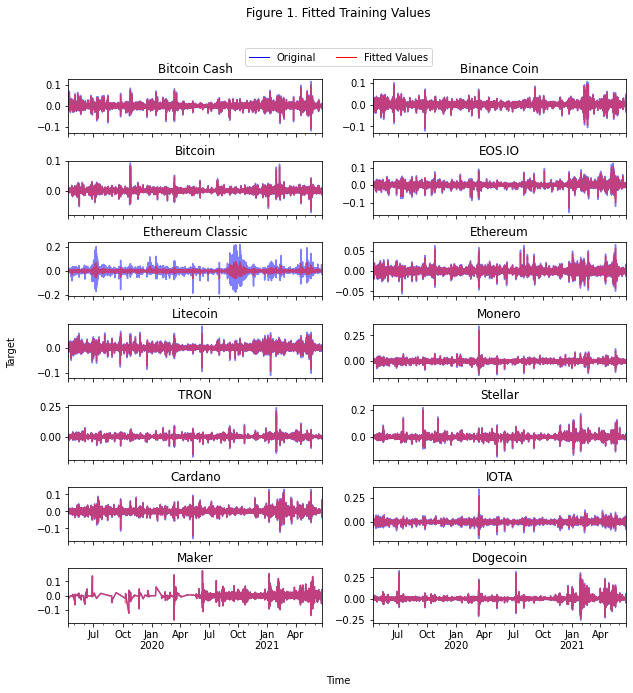

In [14]:
fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    print(i)
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    fitted_values_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [15]:
del fig
del axes

gc.collect()

23

## Plot Forecasts

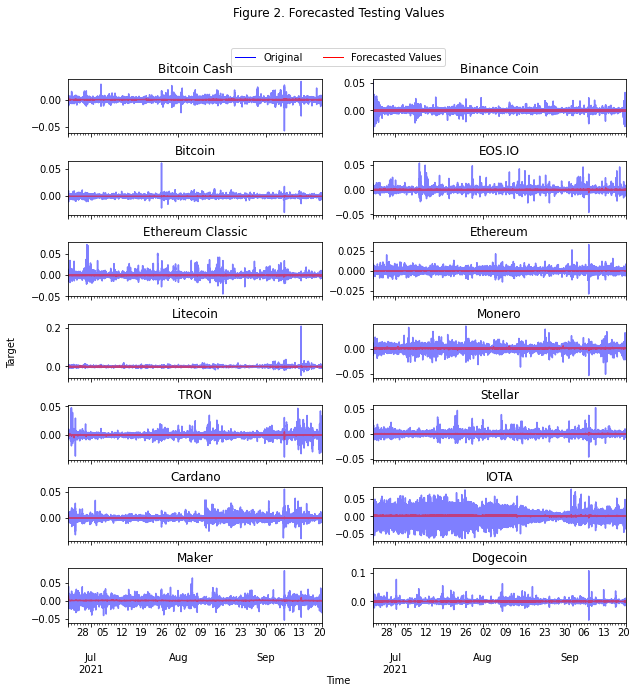

In [17]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

#num = 4
#temp_df = temp_df.iloc[::num, :]
#temp_fit = temp_fit.iloc[::num, :]

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [ ]:
del temp_df
del temp_fit
gc.collect()